# Introduction to the Neuronal Data

### This notebook will show these items:
- how to load the data into PyTorch DataLoaders
- what is contained in the data
 - images
 - neuronal responses
 - behavioral variables
 - anatomical coordinates of each neuron

In [1]:
import torch
import nnfabrik
from nnfabrik.builder import get_data, get_model, get_trainer
import sensorium

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lipstick import GifMaker
from mpl_toolkits import mplot3d
%matplotlib inline

# Instantiate PyTorch DataLoader

In [2]:
filenames = ['../data/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', ]

dataset_fn = 'sensorium.datasets.static_loaders'
dataset_config = {'paths': filenames,
                 'normalize': True,
                 'include_behavior': True,
                 'include_eye_position': True,
                 'batch_size': 128,
                 'exclude': None,
                 'file_tree': True,
                 'scale': 1,
                 'add_behavior_as_channels': False,
                 }

dataloaders = get_data(dataset_fn, dataset_config)

# Show Dataloader

The neuronal data is supplied as a PyTorch DataLoader, already split into the training and validation images. The test set is also available, containing 100 images with 10 repeats each. The two recordings provided for both competition tracks will also have a "test" tier, but they will not contain the ground truth neuronal responses.

In [3]:
dataloaders

OrderedDict([('train',
              OrderedDict([('23964-4-22',
                            <torch.utils.data.dataloader.DataLoader at 0x7fb815128c10>)])),
             ('validation',
              OrderedDict([('23964-4-22',
                            <torch.utils.data.dataloader.DataLoader at 0x7fb814eb2580>)])),
             ('test',
              OrderedDict([('23964-4-22',
                            <torch.utils.data.dataloader.DataLoader at 0x7fb814eb24f0>)])),
             ('final_test',
              OrderedDict([('23964-4-22',
                            <torch.utils.data.dataloader.DataLoader at 0x7fb814eb27c0>)]))])

# Show Content of a batch

In [4]:
tier = 'train'
dataset_name = '23964-4-22'

for batch in dataloaders[tier][dataset_name]:
    pass

In [5]:
# each batch is a NameTuple, containing the images, neuronal responses, and the behavioral variables
print(batch._fields)

('images', 'responses', 'behavior', 'pupil_center')


In [6]:
# Inspecting the content of a batch
for i, field in enumerate(batch._fields):
    print(f"{field}, {batch[i].shape}")

# what will get printed:
# images: N images, channels, height, width
# responses: N images, N neurons
# behavior: N images, N=3 behaviors (pupil size, instantaneous change of pupil size, locomotion speed)
# pupil_center: N images, N=2 eye position traces: horizontal and vertical eye position

images, torch.Size([10, 1, 144, 256])
responses, torch.Size([10, 8098])
behavior, torch.Size([10, 3])
pupil_center, torch.Size([10, 2])


# Get all Images, Responses, and Behaviors

In [7]:
images, responses = [], []
behaviors, eye_positions = [], []

for batch in dataloaders[tier][dataset_name]:
    images.append(batch.images.cpu().data.numpy())
    responses.append(batch.responses.squeeze().cpu().data.numpy())
    behaviors.append(batch.behavior.squeeze().cpu().numpy())
    eye_positions.append(batch.pupil_center.squeeze().cpu().numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)
all_behaviors = np.hstack([np.vstack(behaviors), np.vstack(eye_positions), ])

print('The \"{}\" set of dataset \"{}\" contains the responses of {} neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "23964-4-22" contains the responses of 8098 neurons to 4490 images


# Recreate Plots from Fig. 2 of the White Paper

### Raster Plot

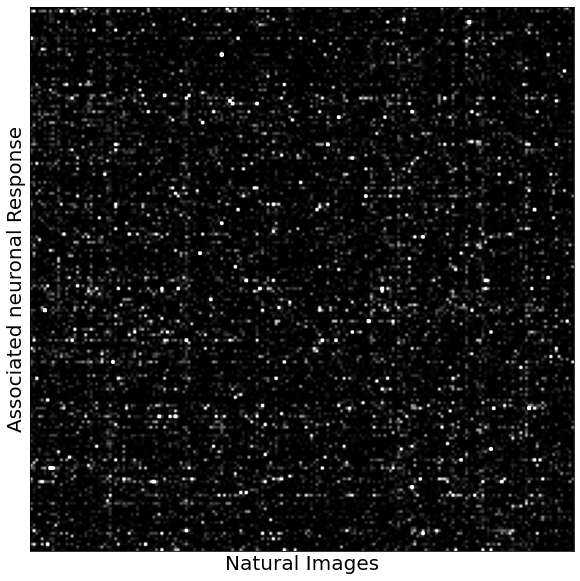

In [8]:
fig,  ax = plt.subplots(1,1, figsize=(10,10))

n_neurons = 200
n_images = 200
ax.imshow(responses[:n_images, :n_neurons], cmap="gray",vmin=0, vmax=5)

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel("Natural Images", fontsize=20, )
ax.set_ylabel("Associated neuronal Response", fontsize=20, );

### Example Behavior Traces

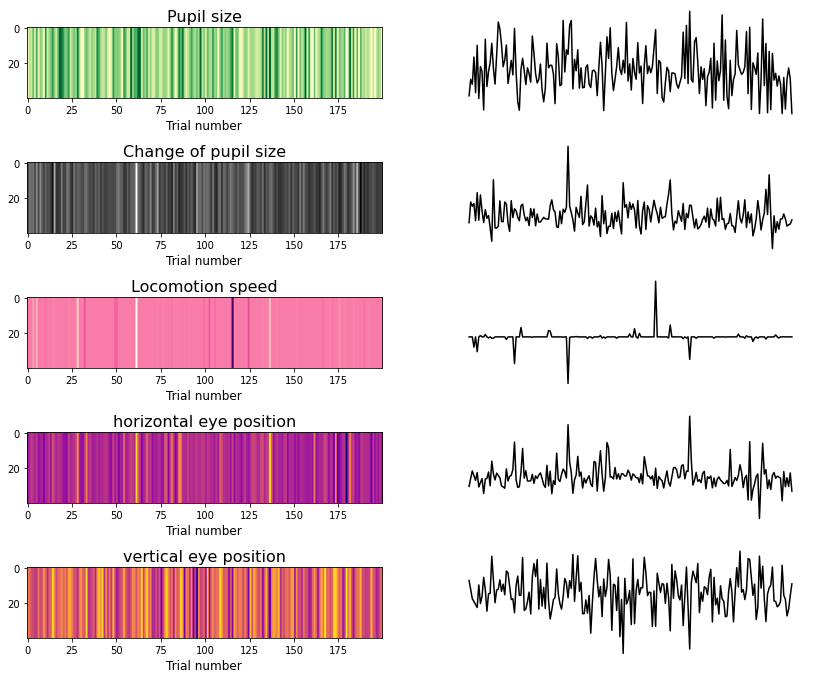

In [9]:
fig, axs = plt.subplots(5,2, figsize=(14,12))

behaviors = ["Pupil size", 
            "Change of pupil size", 
            "Locomotion speed",
            "horizontal eye position",
            "vertical eye position"]
colormaps = ["YlGn", "gray", "RdPu", "plasma", "plasma"]


for i in range(2):
    for behavior in range(5):
        if i == 0:
            axs[behavior, i].imshow(np.tile(all_behaviors[:200, behavior], (40,1)), cmap=colormaps[behavior])
            axs[behavior, i].set_xlabel("Trial number", fontsize=12)
            axs[behavior, i].set_title(behaviors[behavior], fontsize=16)
        else:
            axs[behavior, i].plot(all_behaviors[:200, behavior], 'k-')
            axs[behavior, i].axis("off")

Show Individual Images and the associated response of all neurons

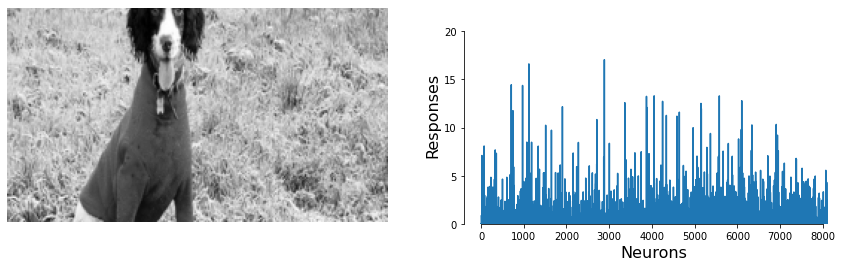

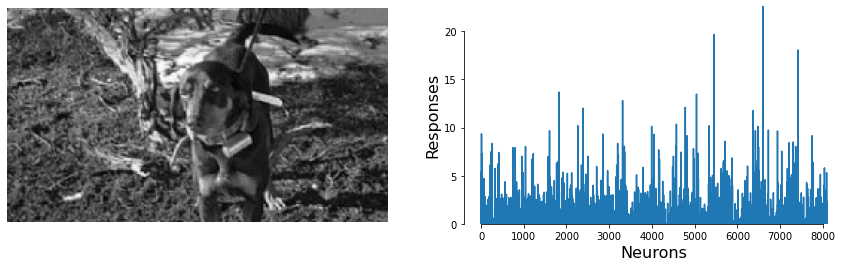

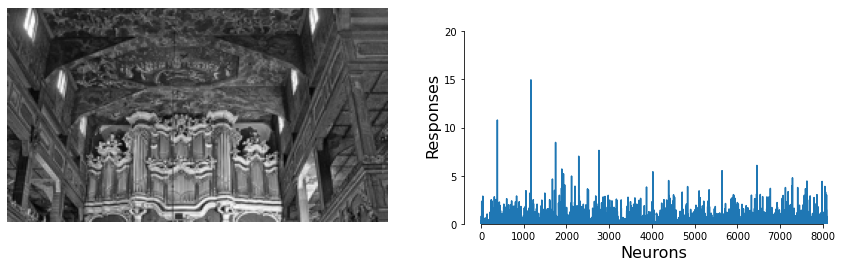

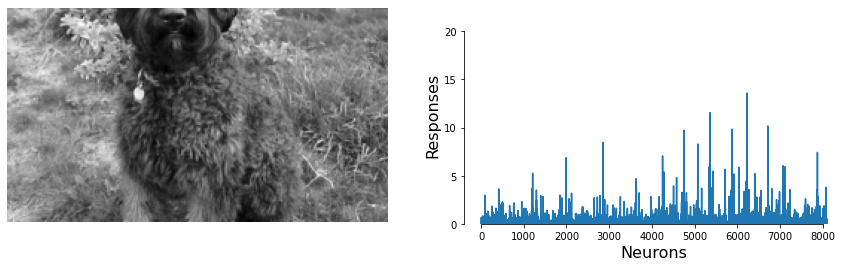

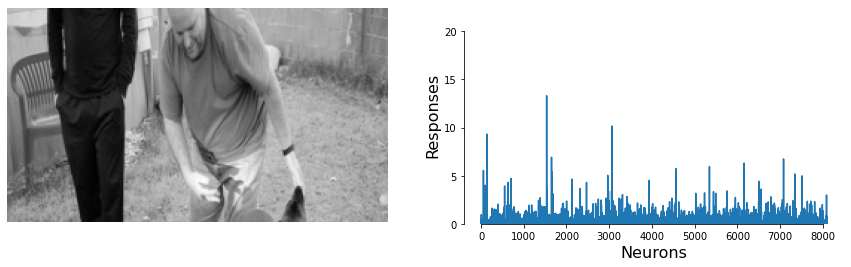

In [10]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i][0], cmap="gray")
    axs[0].axis("off")
    axs[1].plot(responses[i])
    axs[1].set_xlabel('Neurons', fontsize=16)
    axs[1].set_ylabel('Responses', fontsize=16)
    axs[1].set_ylim([0, max_response])
    sns.despine(trim=True)
    plt.show()

# Show Anatomical Coordinates of all Neurons in the recorded Volume

### compute time ~1min

In [ ]:
data_keys = list(dataloaders["train"].keys())

with GifMaker(f"scan_fields_evaluation_mice.gif", fps=24) as g:

    for trial, azimuth in enumerate(np.linspace(0, 360, 180)):
        fig = plt.figure(figsize=(10,10))
        
        for i, data_key in enumerate(data_keys):
            ax = fig.add_subplot(1, 1, i+1, projection='3d')
            cell_motor_coordinates = (dataloaders["train"][data_key].dataset.neurons.cell_motor_coordinates)
            ax.scatter3D(*cell_motor_coordinates.T, c="k", s=15, edgecolor="k", alpha=0.5, cmap="magma")
            ax.view_init(45, azimuth)
            
            # bring all coordinates on the same scale
            ax.set_zlim([100,340])
            ax.set_title(f"Anatomical positions of neurons in Recording {data_key}", fontsize=16)
            ax.set_xlabel('x coordinate', fontsize=16)
            ax.set_ylabel('y coordinate', fontsize=16)
            ax.set_zlabel('z coordinate', fontsize=16)
        g.add(fig)
g.show()